# ML Pipeline Studio - Workflow to Develop Model Training on Vertex AI

1. Define a common sense baseline model

We will create a naive forecast, where we will use the mtb from the previous trip to predict the next trip and measure accuracy

2. Scale up by developing a model that will overfit, showing statisical power

Durring this phase, we will experiment with different datasets and different model architecture.

3. Regularize and tune
Once we establish a model that shows sufficient representational power, we will look to improve accuracy through hp tuning and regularization

In [3]:
import pandas as pd

data = pd.read_csv('full_clean_ml_datset.csv')

data.shape

(107920, 21)

In [4]:
data.head()

,date,duration,mbt,lag_1,lag_2,lag_3,lag_4,lag_5,day_sin,day_cos,...,week_cos,temp,precip,snow,snowdepth,visibility,windspeed,rolling_mean_10,rolling_std_10,rolling_mean_50
0,2024-01-01 00:01:07,24.67,12.95,2.87,4.45,9.33,14.58,16.03,0.004872,0.999988,...,-0.900667,43.1,0.0,0.0,0.0,9.9,6.1,14.153,5.618179,16.6026
1,2024-01-01 00:11:54,25.95,10.78,2.97,4.67,9.58,15.30,16.97,0.051900,0.998652,...,-0.897726,43.1,0.0,0.0,0.0,9.9,6.1,14.153,5.618179,16.6026
2,2024-01-01 00:23:12,24.83,11.30,2.78,4.50,9.17,14.47,16.05,0.101056,0.994881,...,-0.894600,43.1,0.0,0.0,0.0,9.9,6.1,14.153,5.618179,16.6026
3,2024-01-01 00:34:05,24.02,10.88,3.10,4.55,9.27,14.32,15.77,0.148169,0.988962,...,-0.891548,42.2,0.0,0.0,0.0,9.9,6.9,14.153,5.618179,16.6026
4,2024-01-01 00:49:29,26.87,15.40,3.13,4.80,9.80,15.83,17.82,0.214238,0.976781,...,-0.887159,42.2,0.0,0.0,0.0,9.9,6.9,14.153,5.618179,16.6026


In [9]:
data['date'] = pd.to_datetime(data['date'])

time_diff =  data['date'].iloc[175] - data['date'].iloc[0]

diff_in_hours = time_diff.total_seconds() / 3600

print(f"time difference: {time_diff}")
print(f"Time difference in hours: {diff_in_hours:.2f}")

time difference: 1 days 14:11:57
Time difference in hours: 38.20


In [11]:
data['year'] = data['date'].dt.year
year_counts = data['year'].value_counts().sort_index()
print("Number of examples per year:")
print(year_counts)

Number of examples per year:
year
2024    55353
2025    52567
Name: count, dtype: int64


In [ ]:
data = data[data['year'].isin([2023, 2024, 2025])]
print("Data filtered to include only years 2024 and 2025.")
print(data['year'].value_counts().sort_index())

Data filtered to include only years 2024 and 2025.
year
2023    56552
2024    55348
2025    52562
Name: count, dtype: int64


In [13]:
data.iloc[:, 1:].describe().T

,count,mean,std,min,25%,50%,75%,max
duration,107920.0,29.415364,6.168424,0.13000,25.665000,27.330000,30.420000,55.000000
mbt,107920.0,8.198662,5.439243,0.00000,4.370000,6.830000,10.670000,34.900000
lag_1,107920.0,3.287851,1.341595,0.00000,2.780000,2.920000,3.170000,29.550000
lag_2,107920.0,5.123536,1.679315,0.02000,4.420000,4.670000,5.080000,31.630000
lag_3,107920.0,10.279987,2.313872,0.03000,9.250000,9.920000,10.900000,37.870000
lag_4,107920.0,15.845074,3.243247,0.05000,14.830000,15.720000,16.920000,45.420000
lag_5,107920.0,18.360832,3.662353,0.07000,16.920000,18.220000,19.850000,48.370000
day_sin,107920.0,-0.244642,0.604950,-1.00000,-0.798985,-0.345946,0.211129,1.000000
day_cos,107920.0,0.047398,0.756272,-1.00000,-0.781520,0.160061,0.816694,1.000000
week_sin,107920.0,-0.021541,0.736019,-1.00000,-0.807965,-0.090767,0.722055,1.000000


In [36]:
data = data.drop(columns=['lag_1','lag_2','lag_3','lag_4','lag_5','year'], axis=1)

In [37]:
data.head()

,date,duration,mbt,day_sin,day_cos,week_sin,week_cos,temp,precip,snow,snowdepth,visibility,windspeed,rolling_mean_10,rolling_std_10,rolling_mean_50
0,2024-01-01 00:01:07,24.67,12.95,0.004872,0.999988,-0.434511,-0.900667,43.1,0.0,0.0,0.0,9.9,6.1,14.153,5.618179,16.6026
1,2024-01-01 00:11:54,25.95,10.78,0.051900,0.998652,-0.440555,-0.897726,43.1,0.0,0.0,0.0,9.9,6.1,14.153,5.618179,16.6026
2,2024-01-01 00:23:12,24.83,11.30,0.101056,0.994881,-0.446867,-0.894600,43.1,0.0,0.0,0.0,9.9,6.1,14.153,5.618179,16.6026
3,2024-01-01 00:34:05,24.02,10.88,0.148169,0.988962,-0.452926,-0.891548,42.2,0.0,0.0,0.0,9.9,6.9,14.153,5.618179,16.6026
4,2024-01-01 00:49:29,26.87,15.40,0.214238,0.976781,-0.461463,-0.887159,42.2,0.0,0.0,0.0,9.9,6.9,14.153,5.618179,16.6026


In [38]:
data.to_csv('new_full_dataset.csv', header=True, index=False)

In [15]:
import os
from matplotlib import pyplot as plt
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import layers
import model_utils as utils
os.environ['TF_CPP_MINM_LOG_LEVEL'] = '2'

In [40]:
plt.rcParams["figure.figsize"] = (9,6)

In [17]:

fname = os.path.join('new_full_dataset.csv')

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['date', 'duration', 'mbt', 'day_sin', 'day_cos', 'week_sin', 'week_cos', 'temp', 'precip', 'snow', 'snowdepth', 'visibility', 'windspeed', 'rolling_mean_10', 'rolling_std_10', 'rolling_mean_50']
107921


In [42]:
lines = [line for line in lines if line.strip()]

mbt = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    mbt[i] = values[1]
    raw_data[i, :] = values[:]

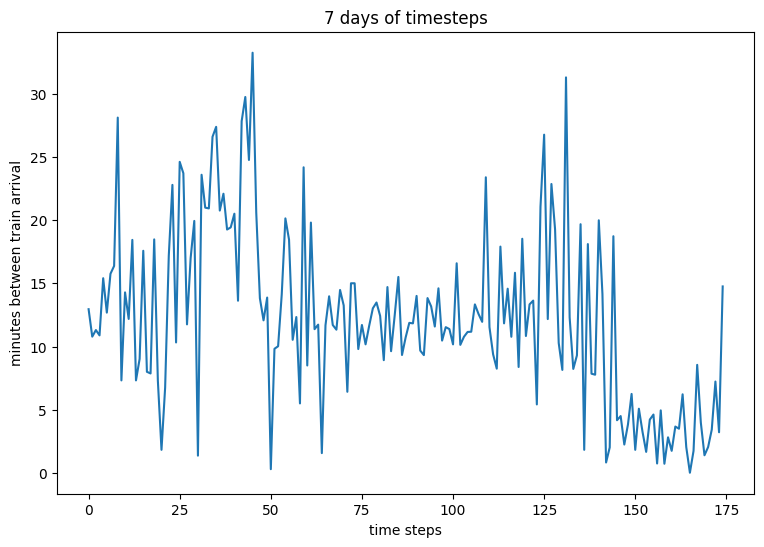

In [20]:
plt.plot(range(len(mbt[0:175])), mbt[0:175])
plt.title('7 days of timesteps')
plt.ylabel('minutes between train arrival')
plt.xlabel('time steps');

In [22]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("Training Samples:", num_train_samples)
print("Validation Samples:", num_val_samples)
print("Test Samples:", num_test_samples)

Training Samples: 53960
Validation Samples: 26980
Test Samples: 26980


In [ ]:
# Standard scaling: (x - mean) / std
# Apply to all columns except the target if needed

# If your target is included in raw_data, exclude it from scaling
# For this example, let's assume all columns should be scaled
train_mean = np.mean(raw_data[:num_train_samples, :], axis=0)
train_std = np.std(raw_data[:num_train_samples, :], axis=0)

# Apply standard scaling to all columns
raw_data = (raw_data - train_mean) / train_std

# Verify the range
print("Means after scaling (should be ~0):", np.mean(raw_data, axis=0))
print("Stds after scaling (should be ~1):", np.std(raw_data, axis=0))


Means after scaling (should be ~0): [-0.02531158  0.02346604 -0.06506809  0.00147931 -0.00487393 -0.00410267
 -0.02374327  0.04626568  0.03255547 -0.03670837  0.0416575 ]
Stds after scaling (should be ~1): [0.98351859 0.99937852 1.05199572 1.24422636 1.01471547 0.90307212
 1.01709158 1.03607298 1.01160023 1.00107059 1.01690068]


In [47]:
import tensorflow as tf
from tensorflow import keras

# --- Configuration ---
sequence_length = 195 # represents roughly 24 hrs of train arrivals
batch_size = 128 # consider A100 gpu

# Uses the first 50% of data (0 to num_train_samples)
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-sequence_length],  # Inputs
    targets=mbt[sequence_length:, None],     # Targets (shifted by seq_length)
    sequence_length=sequence_length,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=True,                      # Shuffle ONLY for training
    start_index=0,
    end_index=num_train_samples
)

# --- 2. Validation Dataset ---
# Uses the next 25% of data
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-sequence_length],
    targets=mbt[sequence_length:, None],
    sequence_length=sequence_length,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,                     # No shuffle for validation
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

# --- 3. Test Dataset ---
# Uses the remaining data
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-sequence_length],
    targets=mbt[sequence_length:, None],
    sequence_length=sequence_length,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,                     # No shuffle for testing
    start_index=num_train_samples + num_val_samples,
    end_index=None                     # Go to the end
)

# --- Verification ---
for inputs, targets in train_dataset.take(1):
    print(f"Input shape: {inputs.shape}")   # (256, 186, 10) -> (Batch, Time, Features)
    print(f"Target shape: {targets.shape}") # (256,)         -> (Batch,)

Input shape: (128, 195, 15)
Target shape: (128, 1)


In [48]:
for inputs, targets in train_dataset.take(1):
    # Select the first example from the batch
    first_input_example = inputs[0]
    first_target_example = targets[0]

    print(f"Shape of one input example: {first_input_example.shape}")
    print(f"Shape of one target example: {first_target_example.shape}")
    print("\nFirst few features of the input example (first 5 timesteps, first 5 features):")
    print(first_input_example[:5, :5])
    print("\nTarget for this example:")
    print(first_target_example)

Shape of one input example: (195, 15)
Shape of one target example: (1,)

First few features of the input example (first 5 timesteps, first 5 features):
tf.Tensor(
[[ 2.72266133  2.20649224  0.97026053 -0.24206302  0.18834048]
 [ 1.29563044  0.56940697  0.9573195  -0.2890318   0.1815    ]
 [ 0.73279033  1.79308687  0.93195514 -0.36257359  0.17055756]
 [ 0.68974023  1.88495473  0.90000202 -0.43588571  0.15928636]
 [ 0.5589955   3.89134879  0.83720206 -0.54689368  0.14126121]], shape=(5, 5), dtype=float64)

Target for this example:
tf.Tensor([3.25], shape=(1,), dtype=float64)


In [49]:
def run_experiment(model, train_ds, val_ds, model_name, epochs=50, patience=5):

    # 1. Optimization Schedule
    # Cosine Decay is excellent, but let's try a slightly more aggressive decay
    lr_schedule = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.001,
        decay_steps=epochs * len(train_ds),
        alpha=0.001 # Decays to 1e-6
    )

    # 2. Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=f"{model_name}.keras",
            save_best_only=True,
            monitor="val_loss",
            mode="min",
            verbose=0
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
            verbose=1
        )
    ]

    # 3. Compile
    # Using AdamW (Adam with Weight Decay) for better generalization
    # Using Huber loss for robust regression
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4),
        loss=keras.losses.Huber(delta=1.0),
        metrics=["mae"]
    )

    # 4. Fit
    print(f"\nStarting training for: {model_name}")
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=1
    )

    return history

# Architecture Experiments

We will experiment with the following architectures:
- Densly Connected Model
- Simple LSTM
- Dropout-Regularized LSTM
- Spacial Dropout
- Dropout Regularized Stacked GRU
- Bidirectional LSTM
- Residual LSTM

# Common Sense Baseline

First we will start with a naive forecast, using the final step in a sequence to predict the next step.  This baseline metric will serve as the benchmark to beat, where we can train a model that shows more statistical power than a random guess.

In [50]:
def evaluate_naive_method(dataset, train_mean, train_std):
    total_abs_err = 0.0
    samples_seen = 0

    # For standard scaling, use mean and std for inverse transform (mbt is column 1)
    mbt_mean = train_mean[1]
    mbt_std = train_std[1]

    for samples, targets in dataset:
        # 1. Get the standardized value from the last time step of the input
        # Shape: (Batch_Size,)
        scaled_last_step = samples[:, -1, 1]

        # 2. Inverse transform to get Real Minutes
        pred_minutes = (scaled_last_step * mbt_std) + mbt_mean

        # 3. Get Targets (already in Real Minutes)
        real_targets = targets.numpy().flatten()

        # 4. Calculate Error (MAE) in Real Minutes
        total_abs_err += np.sum(np.abs(pred_minutes - real_targets))
        samples_seen += samples.shape[0]

    return total_abs_err / samples_seen

print(f"Validation MAE (Real Minutes): {evaluate_naive_method(val_dataset, train_mean, train_std):.2f}")
print(f"Test MAE (Real Minutes): {evaluate_naive_method(test_dataset, train_mean, train_std):.2f}")

Validation MAE (Real Minutes): 4.27
Test MAE (Real Minutes): 4.04


# Interpretation

# Densly Connected Model

In [51]:
model_name = 'Dense Model'

# start with model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# replace Flatten with Reshape
x = layers.Reshape((sequence_length * raw_data.shape[-1],))(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
dense_model = keras.Model(inputs, outputs)

history_dense = run_experiment(
    model=dense_model,
    train_ds=train_dataset,
    val_ds=val_dataset,
    model_name=model_name,
    epochs=20,
    patience=5)


Starting training for: Dense Model
Epoch 1/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 3.6054 - mae: 4.0742 - val_loss: 2.6201 - val_mae: 3.0812
Epoch 2/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.5193 - mae: 2.9776 - val_loss: 2.5731 - val_mae: 3.0340
Epoch 3/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.4367 - mae: 2.8941 - val_loss: 2.5753 - val_mae: 3.0355
Epoch 4/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.3512 - mae: 2.8049 - val_loss: 2.4626 - val_mae: 2.9193
Epoch 5/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.3019 - mae: 2.7552 - val_loss: 2.4729 - val_mae: 2.9302
Epoch 6/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.2596 - mae: 2.7114 - val_loss: 2.4677 - val_mae: 2.9237
Epoch 7/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.2291 - mae: 2.6806 - val_loss: 2.4167 - val_mae: 2.8725
Epoch 8/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.2034 - mae: 2.6542 - val_loss: 2.4063 - val_mae: 2.8629
Epoch 9/20
421/421 

In [52]:
utils.evaluate_model(f"{model_name}.keras", test_dataset)

Loading best model from: Dense Model.keras
Evaluating model on test set...
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2997 - mae: 2.7527
Test MAE: 2.6321


2.632077932357788

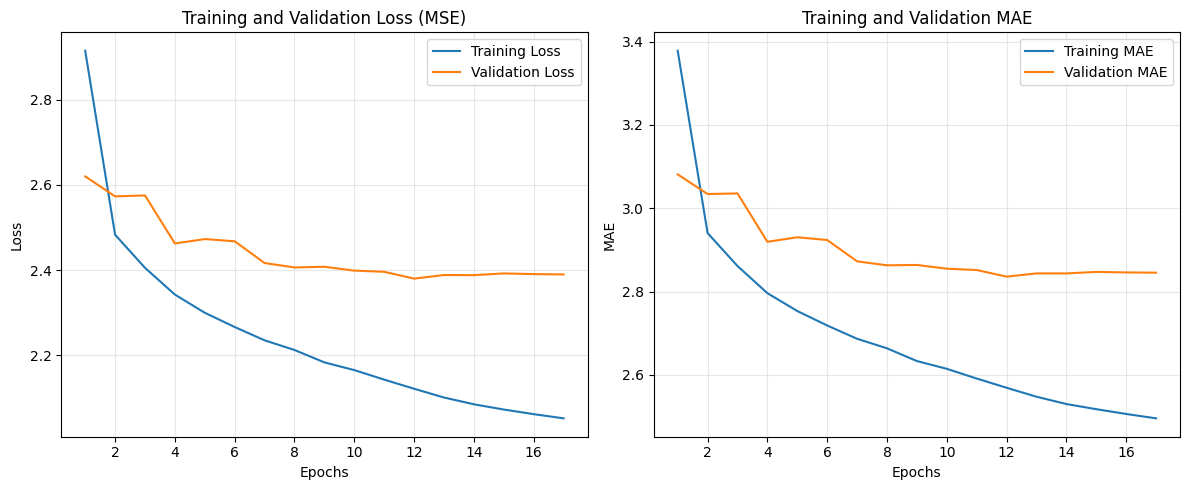

In [53]:
utils.plot_training_history(history_dense, metrics=['mae'])

In [ ]:
# Use model_name as path for forecast context and prediction distribution
utils.plot_forecast_context(
    model_path=f"{model_name}.keras",
    dataset=test_dataset,
    train_mean=train_mean,
    train_std=train_std,
    num_samples=3  # Optional: How many examples to plot
)

In [ ]:
utils.plot_prediction_distribution(f"{model_name}.keras", test_dataset)


# Simple LSTM

In [56]:
model_name = 'simple_lstm'

# model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.LSTM(32)(inputs)

x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1)(x)
lstm_model = keras.Model(inputs, outputs)

# Add the training call here
history = run_experiment(
    model=lstm_model,
    train_ds=train_dataset,
    val_ds=val_dataset,
    model_name=model_name,
    epochs=50,
    patience=5
)


Starting training for: simple_lstm
Epoch 1/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 4.4742 - mae: 4.9499 - val_loss: 2.5734 - val_mae: 3.0317
Epoch 2/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 2.5798 - mae: 3.0393 - val_loss: 2.3353 - val_mae: 2.7901
Epoch 3/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 2.4019 - mae: 2.8574 - val_loss: 2.2092 - val_mae: 2.6610
Epoch 4/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 2.3102 - mae: 2.7641 - val_loss: 2.1512 - val_mae: 2.6023
Epoch 5/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 2.2552 - mae: 2.7082 - val_loss: 2.1211 - val_mae: 2.5703
Epoch 6/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 2.2327 - mae: 2.6838 - val_loss: 2.1038 - val_mae: 2.5539
Epoch 7/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 2.2032 - mae: 2.6539 - val_loss: 2.0901 - val_mae: 2.5392
Epoch 8/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 2.1958 - mae: 2.6473 - val_loss: 2.0765 - val_mae: 2.5264
Epoch 9/50
4

In [57]:
utils.evaluate_model(f"{model_name}.keras", test_dataset)

Loading best model from: simple_lstm.keras
Evaluating model on test set...
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.9515 - mae: 2.3967
Test MAE: 2.3369


2.3369338512420654

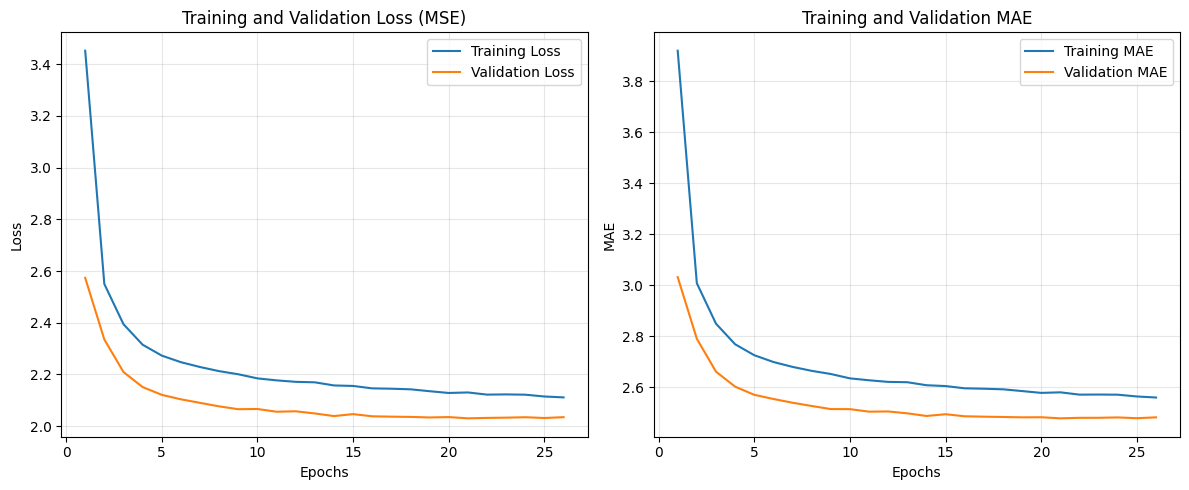

In [58]:
utils.plot_training_history(history, metrics=['mae'])

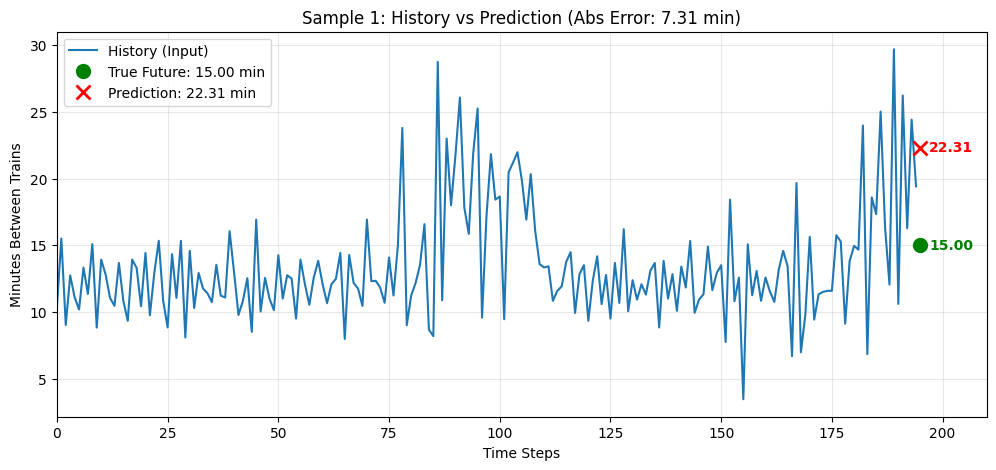

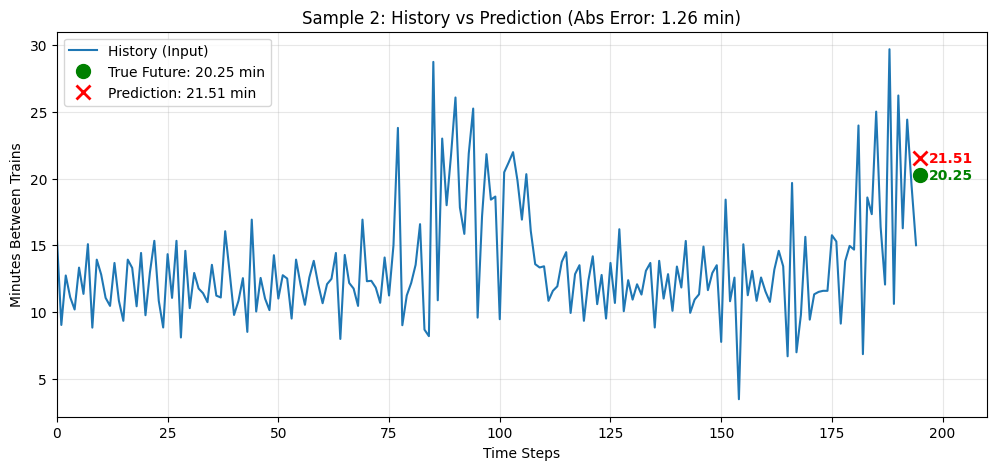

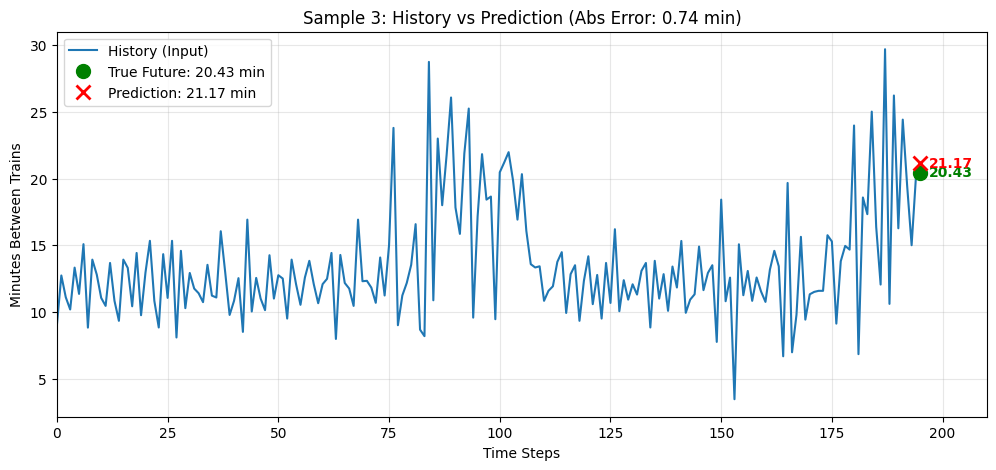

In [ ]:
# Use model_name as path for forecast context and prediction distribution
utils.plot_forecast_context(
    model_path=f"{model_name}.keras",
    dataset=test_dataset,
    train_mean=train_mean,
    train_std=train_std,
    num_samples=3  # Optional: How many examples to plot
)

In [ ]:
utils.plot_prediction_distribution(f"{model_name}.keras", test_dataset)


# Using Spacial Dropout to Fight Overfitting

In [61]:
model_name = 'optimized_gru'
# --- Optimized GRU (Removed Regularizers, Added LayerNorm) ---
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Layer 1: GRU
# Removed L2 Regularization as requested
x = layers.GRU(64, return_sequences=True)(inputs)
x = layers.LayerNormalization()(x) # Added for stability
x = layers.SpatialDropout1D(0.3)(x) # Better for sequences than standard Dropout

# Layer 2: GRU
x = layers.GRU(64, return_sequences=True)(x)
x = layers.LayerNormalization()(x)
x = layers.SpatialDropout1D(0.3)(x)

# Layer 3: GRU
x = layers.GRU(32, return_sequences=False)(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(0.2)(x)

# Dense Head
outputs = layers.Dense(1)(x)

stacked_gru = keras.Model(inputs=inputs, outputs=outputs, name="optimized_gru")

# Use your experiment runner
history_srg = run_experiment(
    model=stacked_gru,
    train_ds=train_dataset,
    val_ds=val_dataset,
    model_name=model_name,
    epochs=100,
    patience=8) # Increased patience slightly


Starting training for: optimized_gru
Epoch 1/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - loss: 3.6481 - mae: 4.1153 - val_loss: 2.3994 - val_mae: 2.8548
Epoch 2/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 2.5639 - mae: 3.0237 - val_loss: 2.1398 - val_mae: 2.5873
Epoch 3/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 2.3972 - mae: 2.8524 - val_loss: 2.0868 - val_mae: 2.5335
Epoch 4/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 2.3315 - mae: 2.7864 - val_loss: 2.0609 - val_mae: 2.5083
Epoch 5/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 2.2781 - mae: 2.7317 - val_loss: 2.0511 - val_mae: 2.4982
Epoch 6/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 2.2340 - mae: 2.6863 - val_loss: 2.0700 - val_mae: 2.5199
Epoch 7/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 2.2172 - mae: 2.6685 - val_loss: 2.0313 - val_mae: 2.4780
Epoch 8/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 2.2004 - mae: 2.6518 - val_loss: 2.0197 - val_mae: 2

In [62]:
utils.evaluate_model(f"{model_name}.keras", test_dataset)

Loading best model from: optimized_gru.keras
Evaluating model on test set...
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.9317 - mae: 2.3739
Test MAE: 2.3142


2.314223051071167

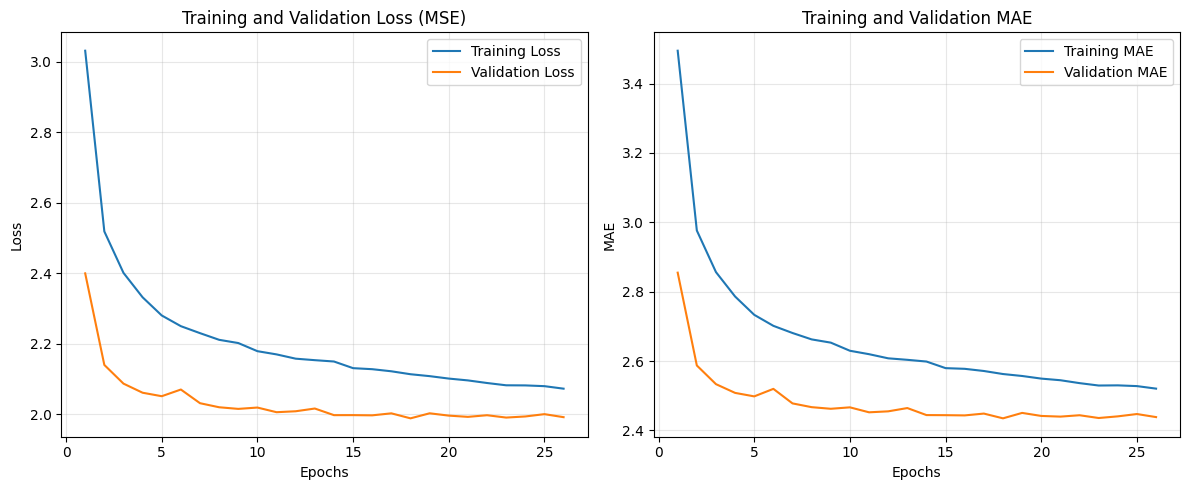

In [63]:
utils.plot_training_history(history_srg, metrics=['mae'])

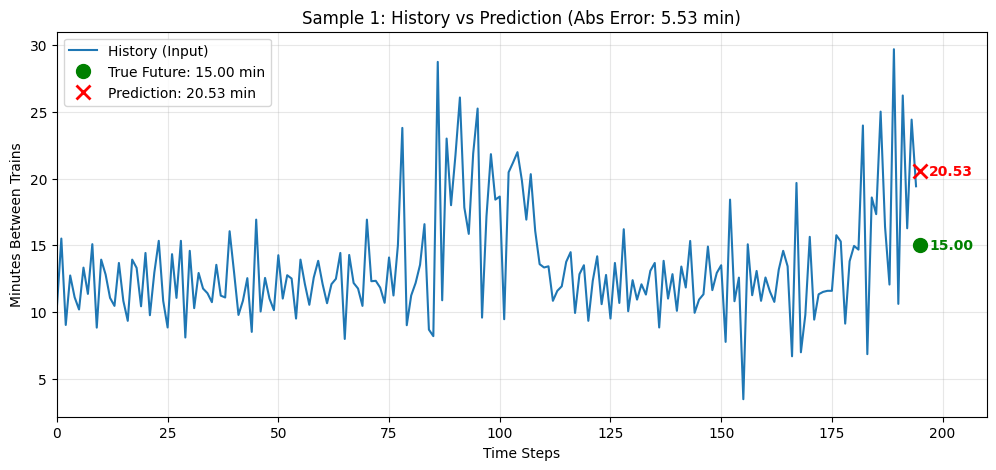

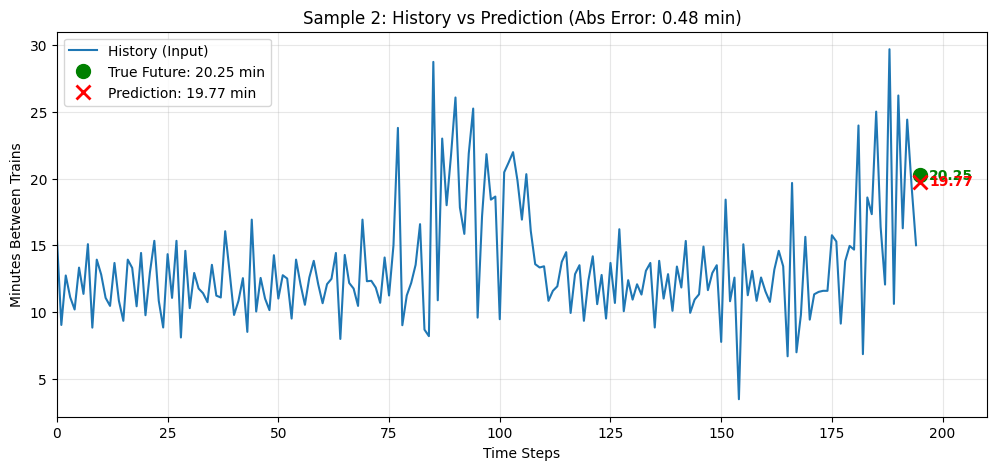

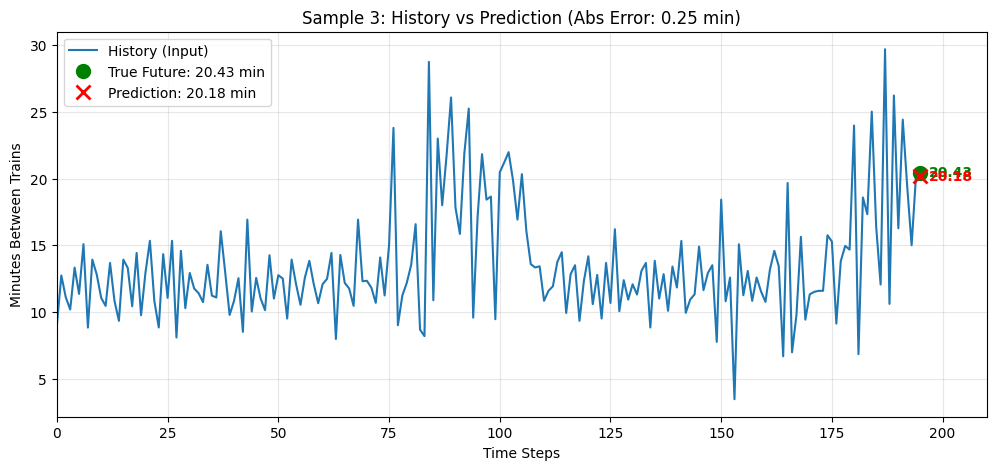

In [ ]:
# Use model_name as path for forecast context and prediction distribution
utils.plot_forecast_context(
    model_path=f"{model_name}.keras",
    dataset=test_dataset,
    train_mean=train_mean,
    train_std=train_std,
    num_samples=3  # Optional: How many examples to plot
)


In [ ]:

utils.plot_prediction_distribution(f"{model_name}.keras", test_dataset)
